In [1]:
import geonetworkx as gnx
import networkx as nx
import geopandas as gpd

import folium
import numpy as np
from mycolorpy import colorlist as mcp

In [2]:
class Colormap(object):
    def __init__(self, data, n=5, cmap="viridis", mode="equal"):

        # the mode describes whether colour classes should be mapped following the "equal interval" or the "quantiles" principle
        self.mode = mode

        # create a list with length n that represents a certain matplotlib colourmap using the package "mycolorpy"
        self.colormap = mcp.gen_color(cmap=cmap, n=n)

        self.data = data
        self.data_min = min(data)
        self.data_max = max(data)
        self.data_range = self.data_max - self.data_min

        # n is the number of classes
        self.n = n

    # create a list with the corresponding colours to all data elements
    def create_color_list(self):

        colors = []

        # iterate over all data elements
        for entry in self.data:
            # iterate over the number of classes
            for i in range(self.n+1):

                # skip the first iteration (with class 0)
                if i == 0:
                    continue
                

                if self.mode == "equal":

                    # check if the scaled value (between 0 and 1) is smaller or equal than the current class fraction (e.g.,  smaller than 0.2 for the 2nd class)
                    if (entry - self.data_min) / self.data_range <= i/self.n:
                        # append the ith color in the colormap to the list
                        colors.append(self.colormap[i-1])
                        break

                elif self.mode == "quantile":
                    # check if the value is smaller or equal than the current class fraction quantile (e.g., smaller than the 0.2 percentile for the 2nd class)
                    if entry <= np.quantile(self.data, i/self.n):
                        colors.append(self.colormap[i-1])
                        break
        
        return colors
    
    def create_color_dictionary(self):

        legend_dict = {}
        # round for better legibility
        value = round(self.data_min, 2)



        for i in range(self.n+1):
            if i == 0:
                continue

            if self.mode == "equal":
                # save the step size between the classes
                data_range_bit = self.data_range / self.n

                # add i times the step size to the minimal value of the data
                tmp = round(self.data_min + data_range_bit * i, 2)

                # add an entry to the dictionary
                legend_dict[f"{value} - {tmp}"] = self.colormap[i-1]

            elif self.mode == "quantile":
                tmp = round(np.quantile(self.data, i/self.n), 2)

                legend_dict[f"{value} - {tmp}"] = self.colormap[i-1]
            
            # set the lower limit for the next class to the upper limit of the current class
            value = tmp

        return legend_dict
    
    def return_max_min(self):
        return self.data_min, self.data_max

In [5]:
edges = gpd.read_file("../data/geodata/streets_zurich_subset_2D_single.geojson")[['OBJECTID', 'ERSTELLUNG', 'BELAGSART', 'OBJEKTART', 'SHAPE_Leng', 'geometry']]
edges['vertices'] = edges.apply(lambda x: [coords for coords in x['geometry'].coords], axis=1)
edges['from'] = edges.apply(lambda x: tuple([round(coord, 3) for coord in x['vertices'][0]]), axis=1)  
edges['to'] = edges.apply(lambda x: tuple([round(coord, 3) for coord in x['vertices'][-1]]), axis=1)  

print("Edges")
edges.head(3)

Edges


OBJECTID  ERSTELLUNG  BELAGSART  OBJEKTART  SHAPE_Leng  \
0   89616.0        2013        100         11  269.349447   
1   89617.0        2013        100         11  121.801884   
2   89618.0        2000        100         10  155.889004   

                                            geometry  \
0  LINESTRING (2681562.891 1247719.956, 2681560.2...   
1  LINESTRING (2681563.681 1247983.984, 2681566.9...   
2  LINESTRING (2681835.480 1247359.379, 2681832.3...   

                                            vertices  \
0  [(2681562.890999999, 1247719.9560000002), (268...   
1  [(2681563.6810000017, 1247983.984000001), (268...   
2  [(2681835.4800000004, 1247359.3790000007), (26...   

                         from                          to  
0  (2681562.891, 1247719.956)  (2681563.681, 1247983.984)  
1  (2681563.681, 1247983.984)   (2681623.005, 1248089.95)  
2   (2681835.48, 1247359.379)  (2681722.211, 1247466.456)

In [4]:
# nodes_from_edges = gpd.GeoDataFrame()

# fid = 0
# for line in edges.iterrows():
#     edges = 
#         print(node)


In [5]:
indices = [0, -1]
    
test = edges.apply(lambda x: [x['geometry'].coords[i] for i in indices ], axis=1)
test

0       [(2681562.890999999, 1247719.9560000002), (268...
1       [(2681563.6810000017, 1247983.984000001), (268...
2       [(2681835.4800000004, 1247359.3790000007), (26...
3       [(2681643.568, 1247548.4699999988), (2681597.4...
4       [(2681538.351, 1247868.8779999986), (2681560.8...
                              ...                        
4685    [(2679673.767999999, 1249122.232999999), (2679...
4686    [(2679690.1779999994, 1249106.0130000003), (26...
4687    [(2679712.6369999982, 1249158.140999999), (267...
4688    [(2679670.8390000015, 1249115.6279999986), (26...
4689    [(2679750.074000001, 1249149.2910000011), (267...
Length: 4690, dtype: object

In [6]:
nodes = gpd.read_file("data/streets_zurich_subset_nodes.geojson")[['fid', 'OBJECTID', 'ERSTELLUNG', 'BELAGSART', 'OBJEKTART', 'SHAPE_Leng', 'geometry']]
nodes['coords'] = nodes.apply(lambda x: tuple(  [round(coord, 3) for coord in x['geometry'].coords[0]]), axis=1)
nodes.drop_duplicates(subset=['coords'], inplace=True)

print("Nodes")
nodes.head(3)

Nodes


fid  OBJECTID  ERSTELLUNG  BELAGSART  OBJEKTART  SHAPE_Leng  \
0    1   89616.0        2013        100         11  269.349447   
1    2   89616.0        2013        100         11  269.349447   
3    4   89617.0        2013        100         11  121.801884   

                          geometry                      coords  
0  POINT (2681562.891 1247719.956)  (2681562.891, 1247719.956)  
1  POINT (2681563.681 1247983.984)  (2681563.681, 1247983.984)  
3  POINT (2681623.005 1248089.950)   (2681623.005, 1248089.95)

In [7]:
edges['from_id'] = edges.apply(lambda x: nodes['fid'][nodes.coords == x['from']].values[0], axis=1)
edges['to_id']   = edges.apply(lambda x: nodes['fid'][nodes.coords == x['to'  ]].values[0], axis=1)
edges = edges.loc[:, edges.columns != "from"]
edges = edges.loc[:, edges.columns != "to"]
edges = edges.loc[:, edges.columns != "vertices"]

print("Edges")
edges.head(3)

Edges


OBJECTID  ERSTELLUNG  BELAGSART  OBJEKTART  SHAPE_Leng  \
0   89616.0        2013        100         11  269.349447   
1   89617.0        2013        100         11  121.801884   
2   89618.0        2000        100         10  155.889004   

                                            geometry  from_id  to_id  
0  LINESTRING (2681562.891 1247719.956, 2681560.2...        1      2  
1  LINESTRING (2681563.681 1247983.984, 2681566.9...        2      4  
2  LINESTRING (2681835.480 1247359.379, 2681832.3...        5      6

In [8]:
edges.to_file("data/streets_zurich_network_edges.geojson", driver="GeoJSON")


/Users/nicibe/miniforge3/envs/networkx/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [9]:
# gg = gnx.GeoGraph()
# gg.add_edges_from_gdf(edges)

In [10]:
gg = gnx.read_geofiles(
    nodes_file_path="data/streets_zurich_subset_nodes.geojson",
    edges_file_path="data/streets_zurich_network_edges.geojson",
    directed=False,
    node_index_attr="fid",
    edge_first_node_attr='from_id',
    edge_second_node_attr='to_id')


In [81]:
# nx.set_edge_attributes(gg, nx.betweenness_centrality(gg), "betweenness")

edge_betweenness_dict = nx.edge_betweenness_centrality(gg, normalized=True)


In [82]:
nx.set_edge_attributes(gg, edge_betweenness_dict, 'betweenness')


In [83]:
gg.get_edge_data(1, 2)

{'OBJECTID': 89616.0,
 'ERSTELLUNG': 2013,
 'BELAGSART': 100,
 'OBJEKTART': 11,
 'SHAPE_Leng': 269.3494467628767,
 'geometry': <shapely.geometry.linestring.LineString at 0x168651270>,
 'betweenness': 4.546745201080943e-08}

<AxesSubplot:>

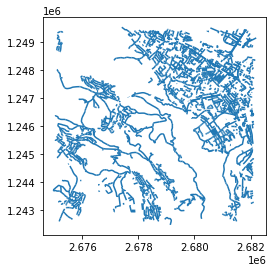

In [88]:
gg_gdf = gg.edges_to_gdf()
gg_gdf['betweenness_standard'] = (gg_gdf.betweenness - gg_gdf.betweenness.mean())/gg_gdf.betweenness.std()

gg_gdf.plot()

In [136]:
cm = Colormap(gg_gdf.betweenness_standard, n=10, mode='quantile')
colors = cm.create_color_list()
color_dict = cm.create_color_dictionary()
color_min, color_max = cm.return_max_min()

In [125]:
def add_categorical_legend(folium_map, title, colors, labels):
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))
    
    legend_categories = ""     
    for label, color in color_by_label.items():
        legend_categories += f"<li><span style='background:{color}'></span>{label}</li>"
        
    legend_html = f"""
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
        {legend_categories}
        </ul>
      </div>
    </div>
    """
    script = f"""
        <script type="text/javascript">
        var oneTimeExecution = (function() {{
                    var executed = false;
                    return function() {{
                        if (!executed) {{
                             var checkExist = setInterval(function() {{
                                       if ((document.getElementsByClassName('leaflet-top leaflet-right').length) || (!executed)) {{
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.display = "flex"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].style.flexDirection = "column"
                                          document.getElementsByClassName('leaflet-top leaflet-right')[0].innerHTML += `{legend_html}`;
                                          clearInterval(checkExist);
                                          executed = true;
                                       }}
                                    }}, 100);
                        }}
                    }};
                }})();
        oneTimeExecution()
        </script>
      """
   

    css = """

    <style type='text/css'>
      .maplegend {
        z-index:9999;
        float:right;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        positon: relative;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    """

    folium_map.get_root().header.add_child(folium.Element(script + css))

    return folium_map

In [137]:
m = folium.Map(
    location = [47.3625, 8.475],
    tiles="cartodbpositron",
    zoom_start=13,
    width='50%',
    height='60%')

m = add_categorical_legend(m, title="Standardized Betweenneess", colors=list(color_dict.values()), labels=list(color_dict))

In [138]:

gg_gdf.explore(
    m=m,
    color=colors)
